<a href="https://colab.research.google.com/github/HeqingZ/CorrectVovnetV2/blob/main/%E6%96%B0_Vovnet_39_3x_1st_Run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount on google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New section

In [2]:
#install detectron2
!python -m pip install pyyaml==5.3.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 269 kB 2.6 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44636 sha256=c77b5f49724757bf39e7c4ba2b2fb1705488a61e62b2905e217b11c29639da5d
  Stored in directory: /root/.cache/pip/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277bff021303bd9570ecea653
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-yn_58etc
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-yn_58etc
     |████████████████████████████████| 50 kB 2.3 MB/s 
     |████████████████████████████████| 79 kB 6

In [3]:
#import some important utilities of Detectron2
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
torch:  1.12 ; cuda:  cu113
detectron2: 0.6


In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
#import features for the bbox
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

from detectron2.structures import BoxMode

In [5]:
"""cpu"""
# !python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cpu/torch1.9/index.html
"""gpu"""    
# !pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install detectron2==0.5 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu110/torch1.7/index.html

!pip install timm
!git clone https://github.com/youngwanLEE/vovnet-detectron2.git vovnet
!curl -OL https://www.dropbox.com/s/q98pypf96rhtd8y/vovnet39_ese_detectron2.pth?dl=1  # pretrained
# !curl -OL https://github.com/emiz6413/SwinT_detectron2/releases/download/v1.3/model_0021209.pth  # trained

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'vovnet'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 94 (delta 59), reused 44 (delta 25), pack-reused 0
Unpacking objects: 100% (94/94), done.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   134    0   134    0     0    383      0 --:--:-- --:--:-- --:--:--   383
100   363  100   363    0     0    463      0 --:--:-- --:--:-- --:--:--   463
100 96.1M  100 96.1M    0     0  36.4M      0  0:00:02  0:00:02 --:--:-- 54.9M


In [6]:
import vovnet

In [7]:
dir(vovnet)

['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__']

In [9]:
import os
from pathlib import Path
from ast import literal_eval

import vovnet
import numpy as np
import pandas as pd
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image

from detectron2.data import (DatasetCatalog, 
                             MetadataCatalog, 
                             build_detection_test_loader
                            )
from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.structures import BoxMode
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
from detectron2.engine import DefaultTrainer, default_setup, hooks
from detectron2.modeling import GeneralizedRCNNWithTTA
from detectron2.evaluation import COCOEvaluator, DatasetEvaluators, inference_on_dataset
 
from vovnet.vovnet import add_vovnet_config
from vovnet.train_net import Trainer

logger = setup_logger()

In [10]:
#define the file path to retrieve images
def FLIR(source_path, img_dir, anno_dir ): #define a function. assuming user doesnt know shit about coding and enter random stuff. related to anno dir and img dir
    img_dir = os.path.join(source_path, img_dir)
    anno_dir = os.path.join(source_path, anno_dir)
    data_dicts = []
    #define annotation properties
    with open(anno_dir) as F:
      jsonfile = json.load(F) #load annotations from json file into the dictionary
    
    annotationinfo = jsonfile["annotations"]
    imagesinfo = jsonfile["images"] #retreieve info like category ID and bbox
   
    #define img sources
     
    img_dir_list = os.listdir(img_dir)#get the list of all files and directories in the specified directory.
    # print(img_dir)
    for img_info in imagesinfo: #bbox info category id
      for images in img_dir_list:  #img_dir_list = img_dir, which is source_path/img_dir(original)
        images = "data/" + images
        if images == img_info['file_name']: #see if name matches each other, because we wanna find the filenames only for the small flir out of the whole json file

          record={}
          filename = os.path.join(source_path, img_info["file_name"])
          # print(filename)
          record["file_name"] = filename
          record["image_id"] = img_info['id']
          record["height"] = img_info['height']
          record['width'] = img_info['width']
        
          box_info = []
          
          for anno in annotationinfo:
            if anno["image_id"] == img_info['id']:
              # if (anno['category_id'] <= 3) & (anno['category_id'] > 0):
              if (anno['category_id'] == 1) & (anno['category_id'] > 0): # Predict people only
                        box = {
                        "bbox": anno['bbox'],
                        'bbox_mode': BoxMode.XYWH_ABS, # Category_id starts from 0 in detectron2
                        'category_id': int(anno['category_id']-1)  #we forcibly convert this shit into integer to be able to minus 1. just incase the stuff from the dict is integer
                        #computer counts from zero but not hyman. we have to substract one to match the computer #update Jun29: i deleted -1, bcz there is no category 0 
                        } #exactly how dictionary looks like
                        imagetesthaha = cv2.imread(filename, 0) 
                        tt = cv2.rectangle(imagetesthaha, anno["bbox"], (255,0,0),2)
                        #cv2_imshow(tt) #for printing all boxes in images one by one, will crash
                        box_info.append(box)
          record["annotations"] = box_info

          data_dicts.append(record)
    return data_dicts

      
      
    #print(type(jsonfile)) #check the  type of jsonfile. dict or list or stuff



#define dataloader for training and testing sets
#train_dataloader = dataloader(training_data, batch_size=64, shuffle=True)
#test_dataloader = dataloader(test_data, batch_size=64, shuffle=True)


In [11]:
def FLIR_dataset_wrapper(source_path, img_dir, anno_dir):
    def wrapper():
        return FLIR(source_path, img_dir, anno_dir)
    return wrapper

In [12]:
DatasetCatalog.clear() #unregister stuff

In [13]:
for d in ["train", "val"]:
    DatasetCatalog.register("FLIR_THERMAL_" + d + "_data", lambda d=d: FLIR("/content/drive/MyDrive/FLIR_THERMAL/"+d, "data", "coco.json")) #changed "/directry/stuff/" +d +"shit" into this rn
    MetadataCatalog.get("FLIR_THERMAL_" + d + "_data").set(thing_classes=["FLIR_THERMAL"])
FLIR_metadata = MetadataCatalog.get("FLIR_THERMAL_train_data")


# for d in ["train", "val"]:
#     DatasetCatalog.register("FLIR_THERMAL_" + d + "_data", lambda d=d: FLIR("/content/drive/MyDrive/SMALL_FLIR_THERMAL/train", "data", "coco.json")) #changed "/directry/stuff/" +d +"shit" into this rn
#     MetadataCatalog.get("FLIR_THERMAL_" + d + "_data").set(thing_classes=["FLIR_THERMAL"])
# FLIR_metadata = MetadataCatalog.get("FLIR_THERMAL_train_data")


In [14]:
convert_to_coco_json('FLIR_THERMAL_train_data', output_file='content/drive/MyDrive/output/inference/FLIR_Thermal_Train_coco_format.json', allow_cached=False)


[09/18 20:52:49 d2.data.datasets.coco]: Converting annotations of dataset 'FLIR_THERMAL_train_data' to COCO format ...)
[09/18 21:05:58 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[09/18 21:06:03 d2.data.datasets.coco]: Conversion finished, #images: 10742, #annotations: 50478
[09/18 21:06:03 d2.data.datasets.coco]: Caching COCO format annotations at 'content/drive/MyDrive/output/inference/FLIR_Thermal_Train_coco_format.json' ...


In [15]:
#to varify our thing by calling the function
dataset_dicts = FLIR("/content/drive/MyDrive/FLIR_THERMAL/train", "data", "coco.json")


In [16]:
!nvidia-smi

Sun Sep 18 21:16:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    46W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
'''
try parameters:
   warmup 5000
   lr 0.0001 
   ims per batch 4
   3x

'''


In [ ]:
'''
for both config file and training code block settings: 
cfg.SOLVER.IMS_PER_BATCH = 4  # This is the real "batch size" commonly known to deep learning people 'changed to 5'
cfg.SOLVER.BASE_LR = 0.0025 #SET ALL TO 0.01
cfg.SOLVER.MAX_ITER = 90000    # 270000 for 3x (F)
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.SOLVER.WARMUP_FACTOR = 1.0 / 5000
cfg.SOLVER.WARMUP_ITERS = 5000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512 
'''


In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [17]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
add_vovnet_config(cfg)
# cfg.MODEL.RESNETS.DEPTH = 50 
cfg.merge_from_file("/content/vovnet/configs/faster_rcnn_V_39_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = ""

cfg.DATASETS.TRAIN = ("FLIR_THERMAL_train_data",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 4  # This is the real "batch size" commonly known to deep learning people 'changed to 5'
cfg.SOLVER.BASE_LR = 0.0001 #SET ALL TO 0.01
cfg.SOLVER.MAX_ITER = 270000    # 270000 for 3x (F)
# cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.SOLVER.WARMUP_FACTOR = 1.0 / 5000
cfg.SOLVER.WARMUP_ITERS = 5000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # chose 512 for 3x
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (people). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.MODEL.MASK_ON = False
# cfg.MODEL.RESNETS.DEFORM_MODULATED = True
cfg.MODEL.BACKBONE.FREEZE_AT = -1
cfg.OUTPUT_DIR = "/content/drive/MyDrive/VovnetFRCN-v2-39-3x"

# !python /content/vovnet/train_net.py --config-file /content/vovnet/configs/faster_rcnn_V_39_FPN_3x.yaml --num-gpus 8

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg)
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

WARNING [09/18 21:16:23 d2.config.compat]: Config '/content/vovnet/configs/faster_rcnn_V_39_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
[09/18 21:16:27 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): VoVNet(
      (stem): Sequential(
        (stem_1/conv): Conv2d(

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/18 21:27:33 d2.utils.events]:  eta: 2:26:01  iter: 220019  total_loss: 0.4568  loss_cls: 0.122  loss_box_reg: 0.2295  loss_rpn_cls: 0.01582  loss_rpn_loc: 0.08078  time: 0.1744  data_time: 0.0167  lr: 1e-05  max_mem: 5468M
[09/18 21:27:37 d2.utils.events]:  eta: 2:28:27  iter: 220039  total_loss: 0.4846  loss_cls: 0.1266  loss_box_reg: 0.2513  loss_rpn_cls: 0.01186  loss_rpn_loc: 0.07573  time: 0.1766  data_time: 0.0089  lr: 1e-05  max_mem: 5468M
[09/18 21:27:40 d2.utils.events]:  eta: 2:28:04  iter: 220059  total_loss: 0.428  loss_cls: 0.1237  loss_box_reg: 0.2196  loss_rpn_cls: 0.01459  loss_rpn_loc: 0.07096  time: 0.1758  data_time: 0.0085  lr: 1e-05  max_mem: 5468M
[09/18 21:27:44 d2.utils.events]:  eta: 2:27:49  iter: 220079  total_loss: 0.3873  loss_cls: 0.1156  loss_box_reg: 0.1976  loss_rpn_cls: 0.01168  loss_rpn_loc: 0.07406  time: 0.1754  data_time: 0.0088  lr: 1e-05  max_mem: 5468M
[09/18 21:27:47 d2.utils.events]:  eta: 2:27:53  iter: 220099  total_loss: 0.4432  loss_cl

KeyError: ignored

In [18]:
from detectron2.utils.visualizer import ColorMode

#Use the final weights generated after successful training for inference  
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# 
print(cfg)

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # ALL THRESHOLD = 0.5
#Pass the validation datasetCORRECTSwinT3xThirdTime
cfg.DATASETS.TEST = ("boardetect_val", )
# cfg.DATASETS.TEST = ("FLIR_THERMAL_train_data", )

predictor = DefaultPredictor(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 2
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('coco_2017_val',)
  TRAIN: ('FLIR_THERMAL_train_data',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: -1
    NAME: build_vovnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATURES: 

(512, 640, 3)


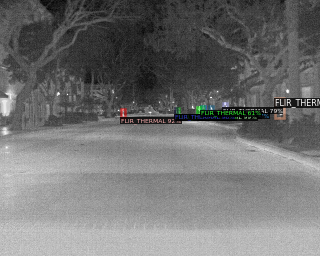

(512, 640, 3)


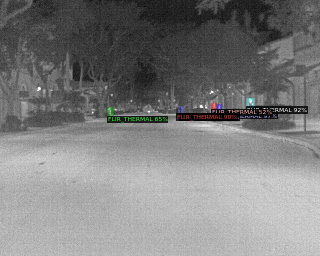

(512, 640, 3)


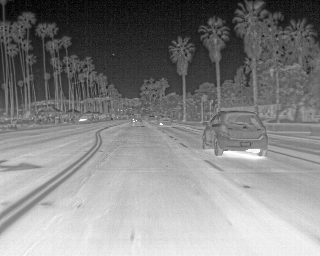

(512, 640, 3)


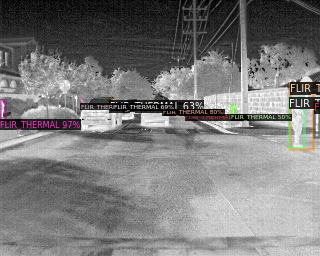

(512, 640, 3)


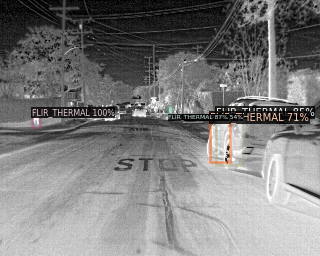

In [19]:
#see if this shit is wroking aka run instance on test images
from detectron2.utils.visualizer import ColorMode
import numpy as np
dataset_dicts = FLIR("/content/drive/MyDrive/FLIR_THERMAL/val/", "data", "coco.json")
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    print(np.shape(im))
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=FLIR_metadata, 
                   scale=0.5, 
                      # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [20]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 #ALL THRESHOLD = 0.5 
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("FLIR_THERMAL_val_data", cfg, False, output_dir="content/output/")
val_loader = build_detection_test_loader(cfg, "FLIR_THERMAL_val_data")
inference_on_dataset(trainer.model, val_loader, evaluator)

[09/19 01:19:39 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                                    | Names in Checkpoint                                                                               | Shapes                          |
|:------------------------------------------------------------------|:--------------------------------------------------------------------------------------------------|:--------------------------------|
| backbone.bottom_up.stage2.OSA2_1.concat.OSA2_1_concat/conv.weight | backbone.bottom_up.stage2.OSA2_1.concat.OSA2_1_concat/conv.weight                                 | (256, 768, 1, 1)                |
| backbone.bottom_up.stage2.OSA2_1.concat.OSA2_1_concat/norm.*      | backbone.bottom_up.stage2.OSA2_1.concat.OSA2_1_concat/norm.{bias,running_mean,running_var,weight} | (256,) (256,) (256,) (256,)     |
| backbone.bottom_up.stage2.OSA2_1.ese.fc.*                         | backbone.bottom_up.stage2.O

OrderedDict([('bbox',
              {'AP': 38.473017742998806,
               'AP50': 75.95077332036236,
               'AP75': 35.10981145721814,
               'APs': 36.57556533716118,
               'APm': 48.01595245305657,
               'APl': 38.339154910907666})])